# This is a difficult regression task, where the aim is to predict the burned area of forest fires, in the northeast region of Portugal, by using meteorological

# X, Y: Spatial coordinates (possibly longitude and latitude).
# month, day: Date of the wildfire.
# FFMC, DMC, DC, ISI: Fire danger indices calculated based on weather and fuel conditions.
# temp, RH, wind: Current weather conditions during the wildfire.
# rain: Recent rainfall amount near the wildfire.
# area: Burned area by the wildfire in hectares.

# Additional Observations:
# The data likely covers multiple wildfire events from different locations.
# The fire danger indices (FFMC, DMC, DC, ISI) can be used to assess the potential severity of fire spread.
# The weather conditions (temp, RH, wind) and recent rainfall (rain) might influence the wildfire behavior.
# The burned area (area) measures the impact of each wildfire event.

# Recommendations for Further Analysis:
# Explore the distribution of each variable using visualizations like histograms and boxplots.
# Check for correlations between variables like fire danger indices, weather conditions, and burned area.
# Group the data by month or location to compare wildfire characteristics across different periods or regions.

## Main Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
import missingno as mis

from sklearn.model_selection import train_test_split


# pr-eprocessing 
from sklearn.pipeline import Pipeline , FeatureUnion
from sklearn_features.transformers import DataFrameSelector
from sklearn.preprocessing import LabelEncoder , StandardScaler
from sklearn.impute import SimpleImputer


# model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split , cross_val_score , cross_val_predict , GridSearchCV , RandomizedSearchCV

from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [3]:
path_data = r"D:\ML_data\forest+fires\forestfires.csv"

if os.path.exists(path_data):
    df = pd.read_csv(path_data)
    print(df.head())
    
else:
    print("Sorry , your path of datasets Not Found.")

   X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [5]:
df.describe().T

count        mean         std   min    25%     50%     75%      max
X     517.0    4.669246    2.313778   1.0    3.0    4.00    7.00     9.00
Y     517.0    4.299807    1.229900   2.0    4.0    4.00    5.00     9.00
FFMC  517.0   90.644681    5.520111  18.7   90.2   91.60   92.90    96.20
DMC   517.0  110.872340   64.046482   1.1   68.6  108.30  142.40   291.30
DC    517.0  547.940039  248.066192   7.9  437.7  664.20  713.90   860.60
ISI   517.0    9.021663    4.559477   0.0    6.5    8.40   10.80    56.10
temp  517.0   18.889168    5.806625   2.2   15.5   19.30   22.80    33.30
RH    517.0   44.288201   16.317469  15.0   33.0   42.00   53.00   100.00
wind  517.0    4.017602    1.791653   0.4    2.7    4.00    4.90     9.40
rain  517.0    0.021663    0.295959   0.0    0.0    0.00    0.00     6.40
area  517.0   12.847292   63.655818   0.0    0.0    0.52    6.57  1090.84

In [6]:
df.describe(include=object).T

count unique  top freq
month   517     12  aug  184
day     517      7  sun   95

In [7]:
df.shape

(517, 13)

In [8]:
df.isna().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

<Axes: >

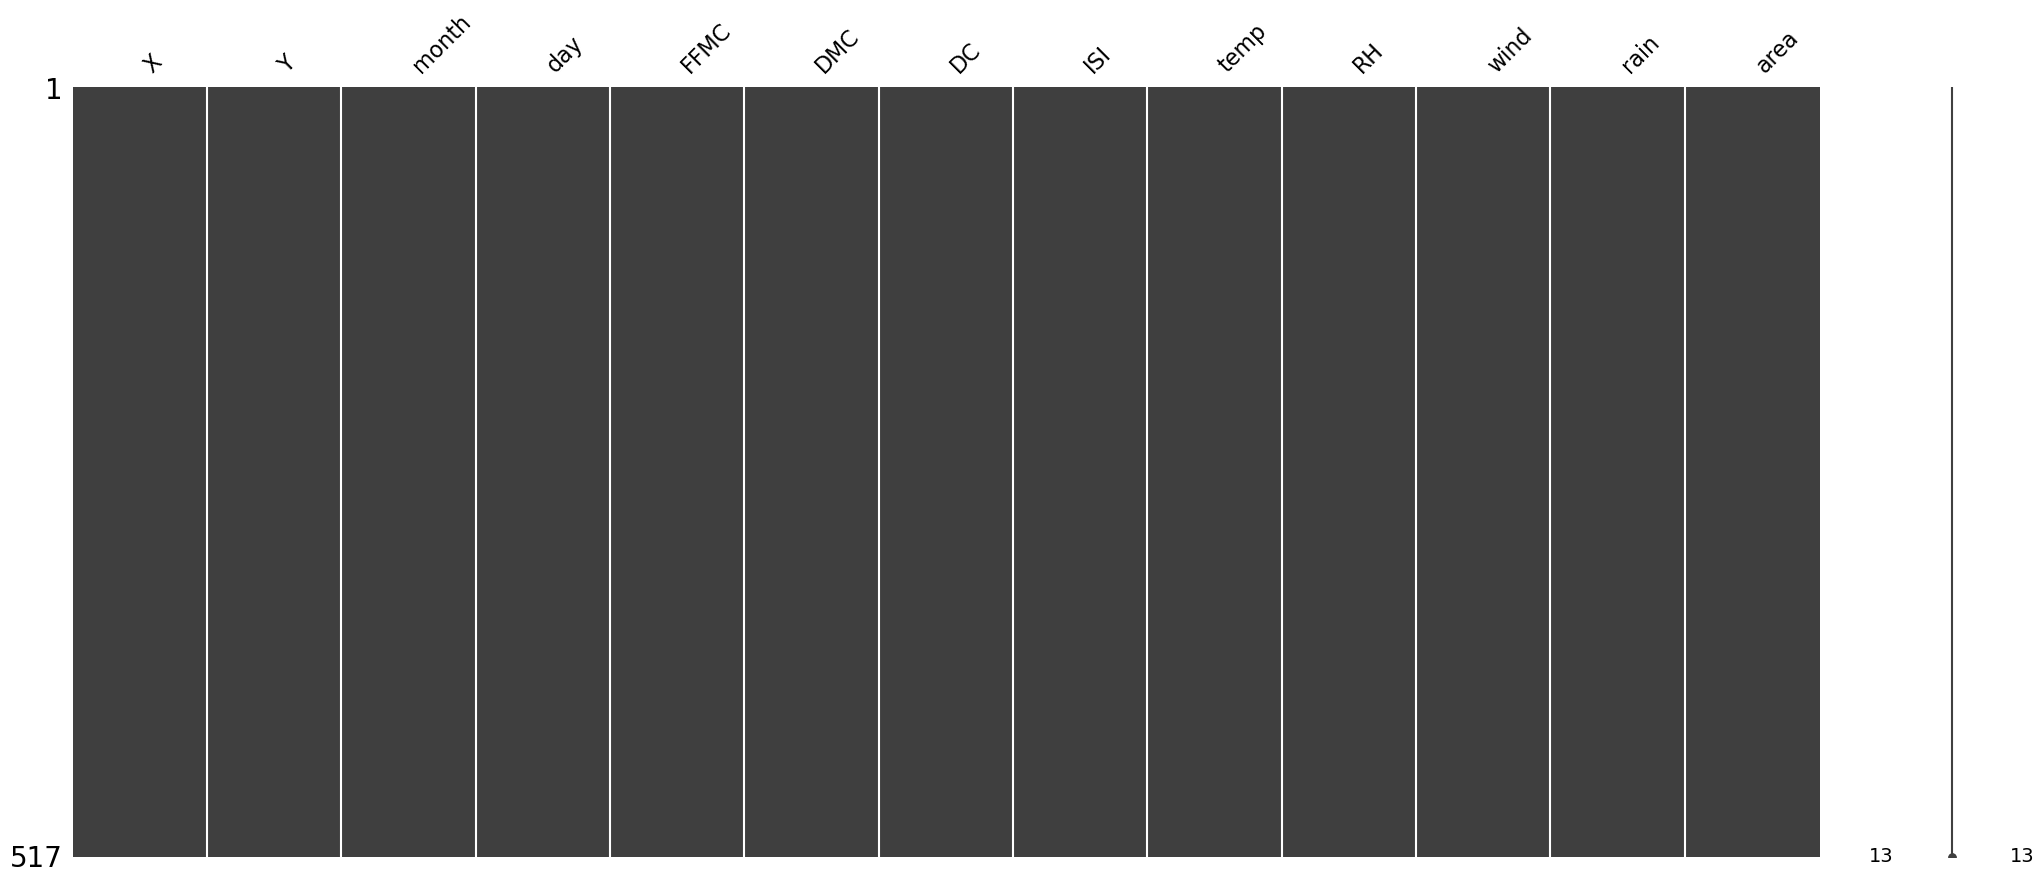

In [9]:
mis.matrix(df)

<Axes: >

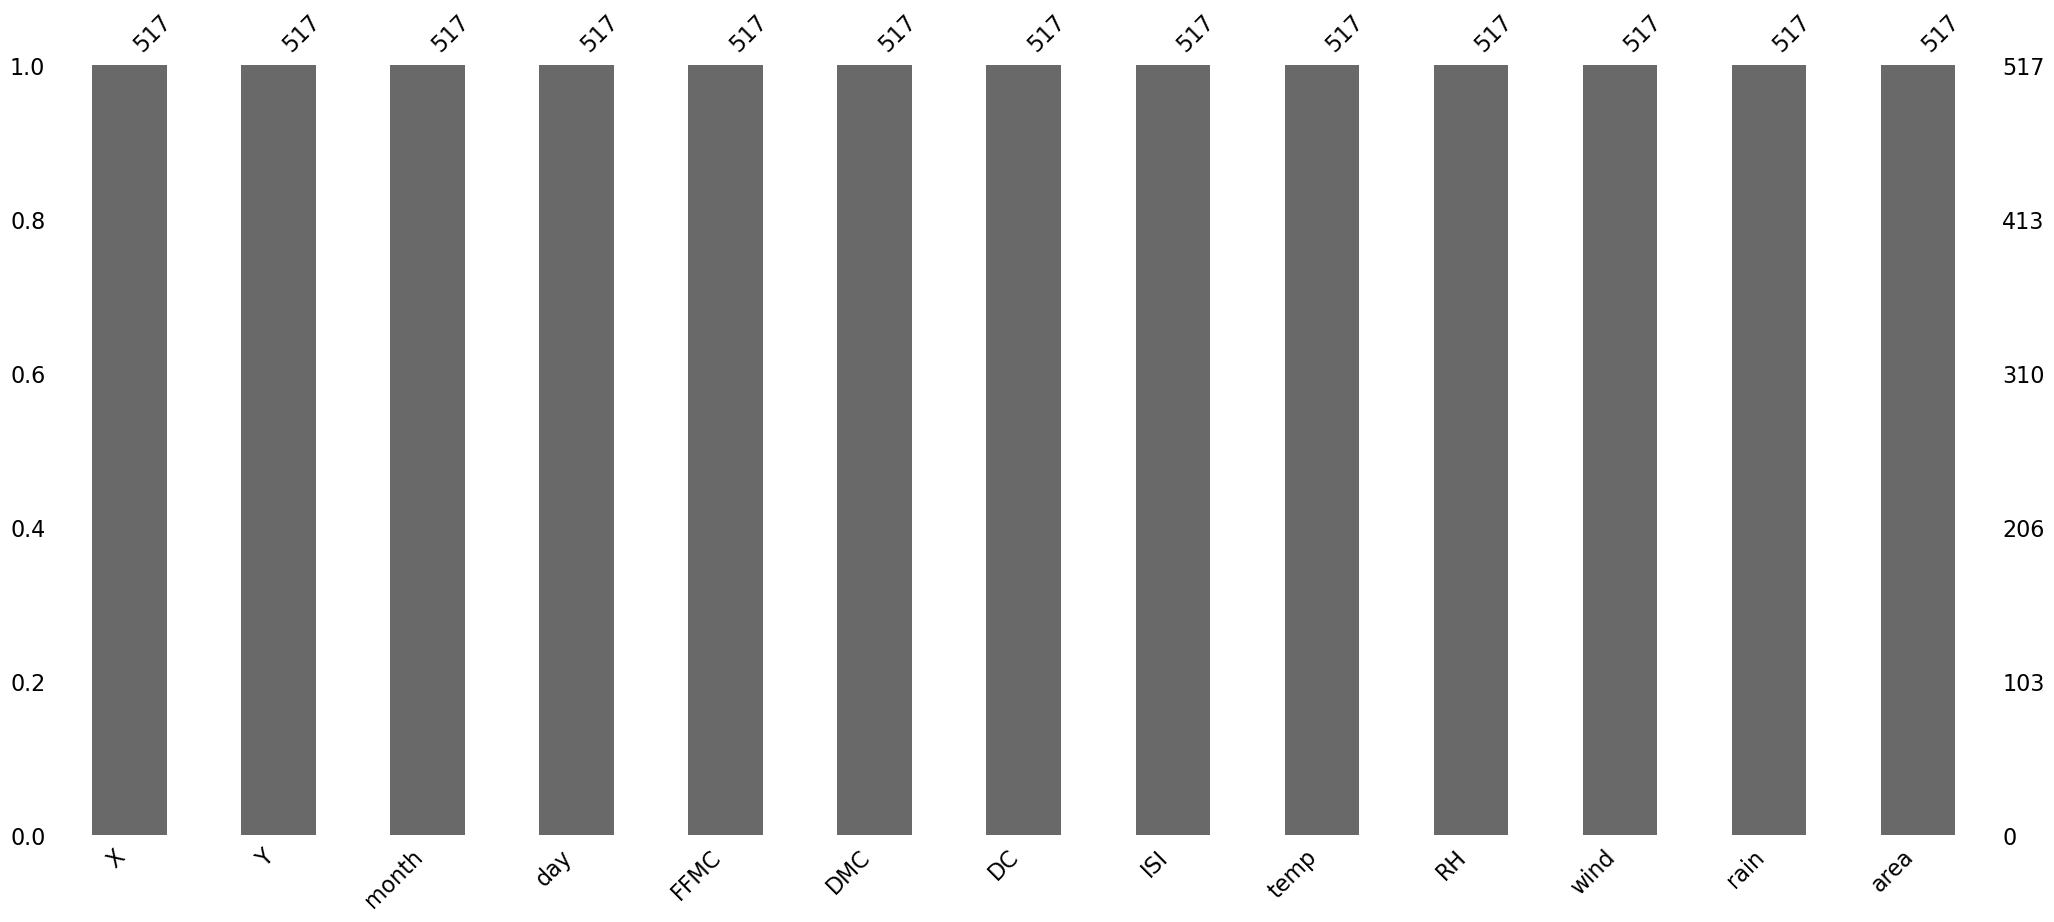

In [10]:
mis.bar(df)

In [11]:
df.columns

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'area'],
      dtype='object')

# Exploratory Data Analysis (EDA)

In [12]:
fig = px.scatter(df, x="area", y="X", title="Relationship Between Burned Area and X-Coordinate")
fig.update_layout(
    xaxis_title="Burned Area (hectares)",
    yaxis_title="X-Coordinate", 
)
fig.show()


In [13]:
fig = px.scatter(df, x="area", y="Y", title="Relationship Between Burned Area and Y-Coordinate")
fig.update_layout(
    xaxis_title="Burned Area (hectares)",
    yaxis_title="Y-Coordinate", 
)
fig.show()


In [14]:
df["month"].value_counts()

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64

In [15]:
datamo = {'month': ['aug', 'sep', 'mar', 'jul', 'feb', 'jun', 'oct', 'apr', 'dec', 'jan', 'may', 'nov'],
        'count': [184, 172, 54, 32, 20, 17, 15, 9, 9, 2, 2, 1]}
datamo = pd.DataFrame(datamo)

# Create the pie chart with informative title and color-coded slices
fig = px.pie(datamo, values='count', names='month',
            title='Distribution of Counts by Month', color='month', color_discrete_sequence=px.colors.qualitative.Set2)

# Customize appearance (optional)
fig.update_traces(textposition='inside', textinfo='percent+label+value', hole=0.5)

# Show the chart
fig.show()


In [16]:
df["day"].value_counts()

sun    95
fri    85
sat    84
mon    74
tue    64
thu    61
wed    54
Name: day, dtype: int64

In [17]:
dataday = {'day': ['sun', 'fri', 'sat', 'mon', 'tue', 'thu','wed'],
        'count': [95, 85, 84, 74, 64, 61, 54]}
dataday = pd.DataFrame(dataday)

# Create the pie chart with informative title and color-coded slices
fig = px.pie(dataday, values='count', names='day',
            title='Distribution of Counts by Days', color='day', color_discrete_sequence=px.colors.qualitative.Set2)

# Customize appearance (optional)
fig.update_traces(textposition='inside', textinfo='percent+label+value', hole=0.5)

# Show the chart
fig.show()


In [18]:
datamo = pd.DataFrame(datamo)

# Create the boxplot with informative title and color-coding
fig = px.box(datamo, x="month", title="Distribution of Count by Month", color="month", color_discrete_sequence=px.colors.qualitative.Set2)

# Show the chart
fig.show()


In [19]:
len(df.columns)

13

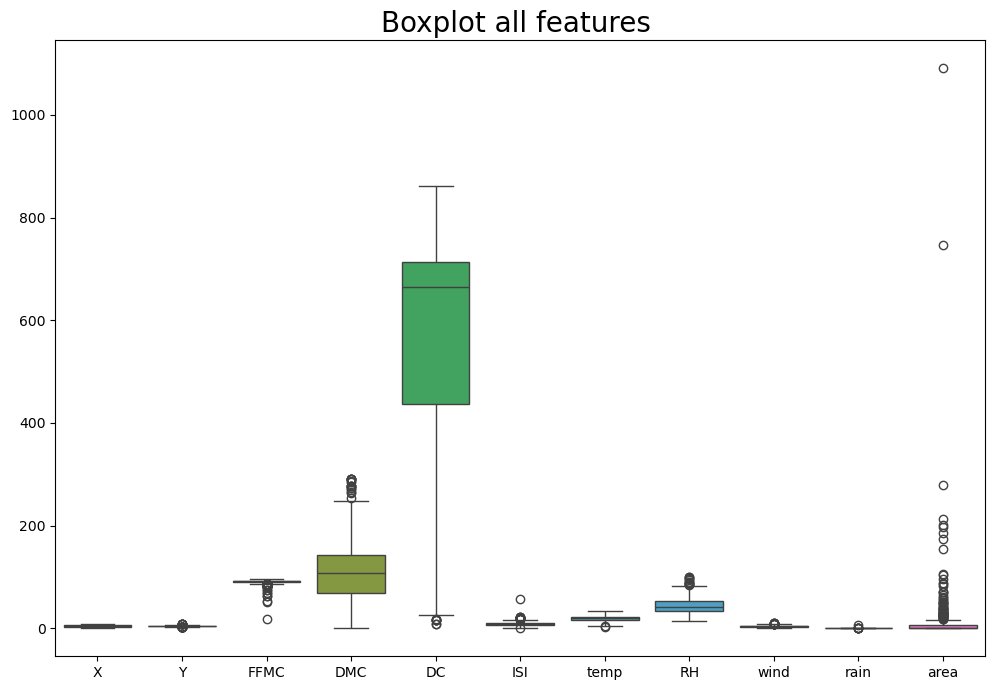

In [20]:
plt.figure(figsize=(12,8))
sns.boxplot(df)
plt.title("Boxplot all features " , fontsize=20)
plt.show()

In [21]:
# Create histogram
fig = px.histogram(datamo, x="month", color="month")

# Show histogram
fig.show()


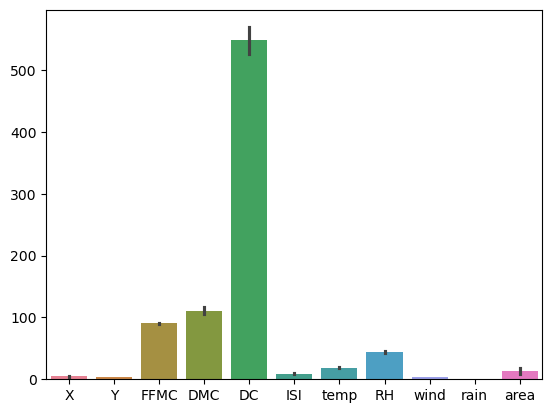

In [22]:
sns.barplot(df)
plt.show()

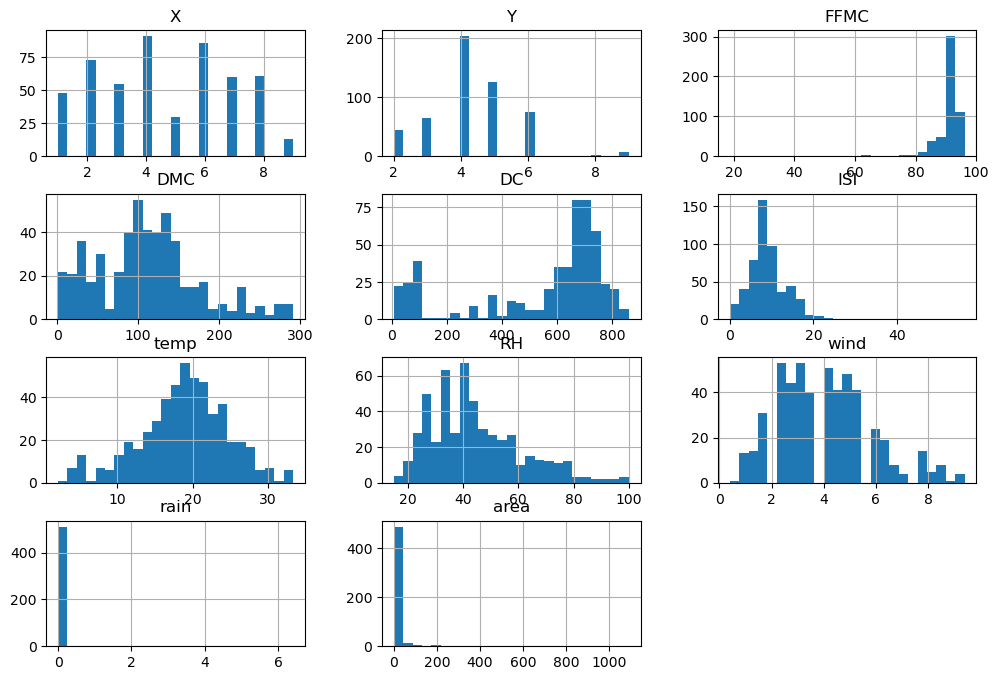

In [23]:
df.hist(figsize=(12, 8), bins=25)
plt.show()

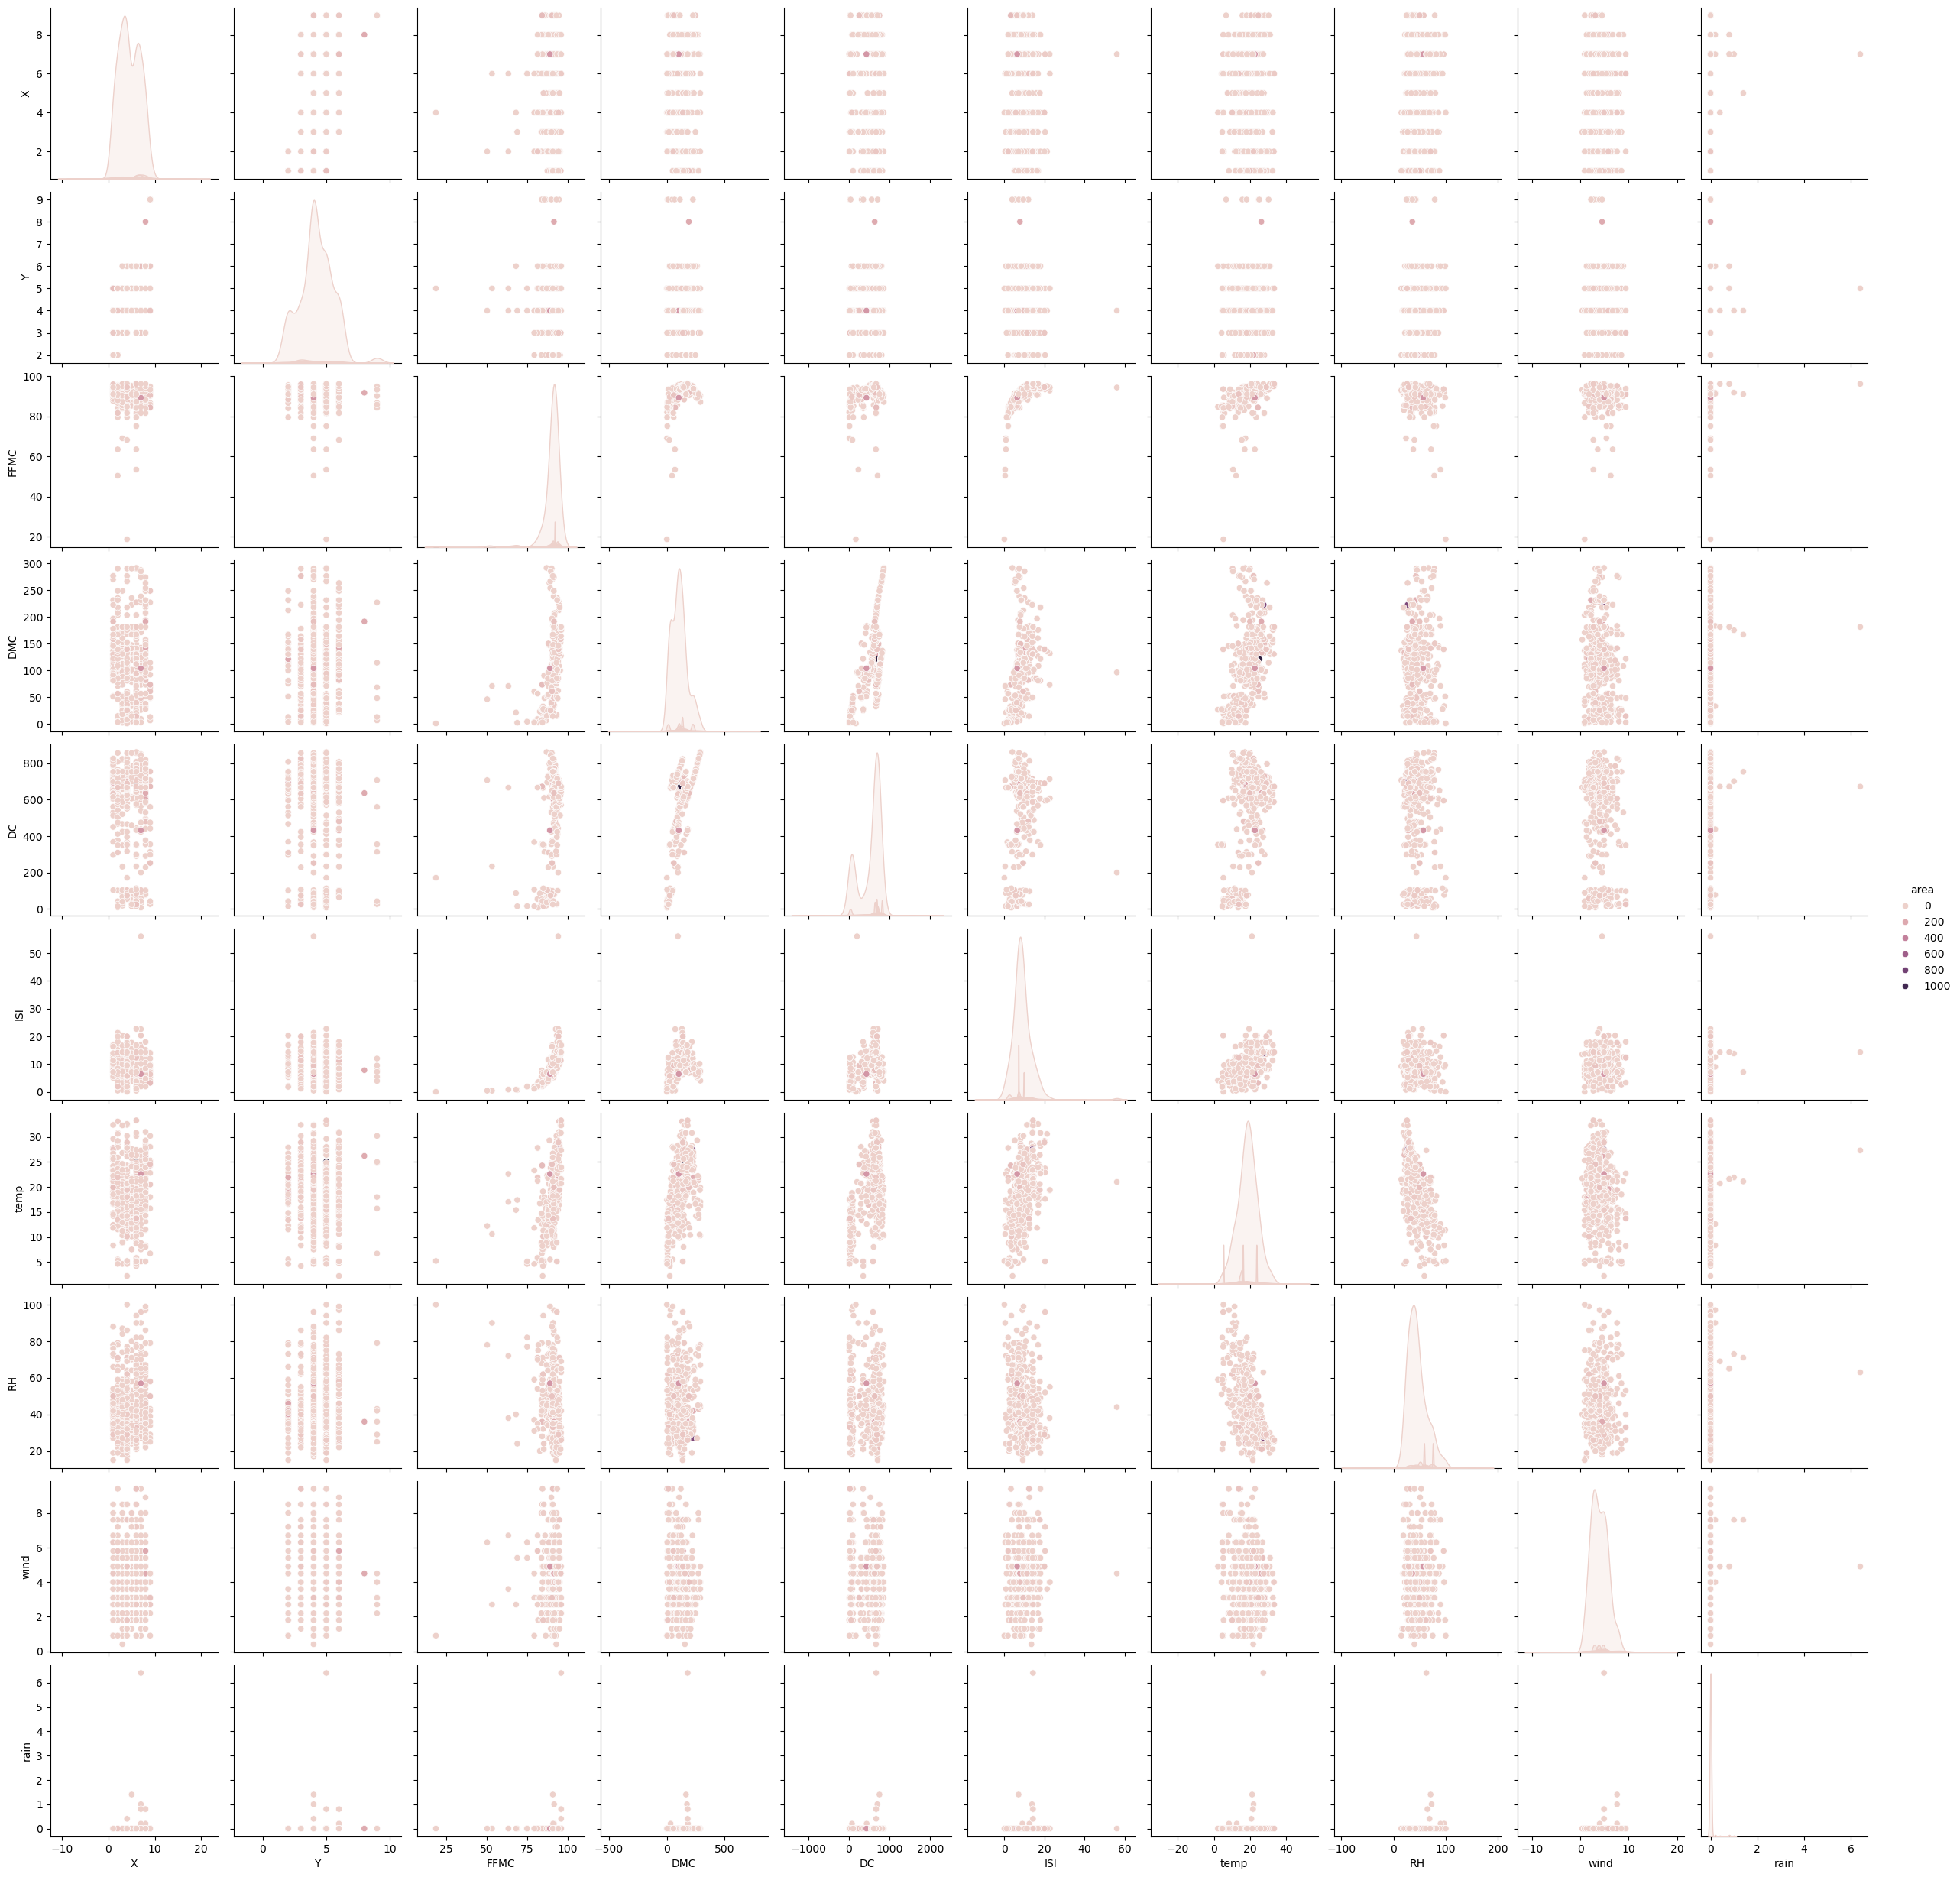

In [24]:
sns.pairplot(df , hue="area")
plt.show()

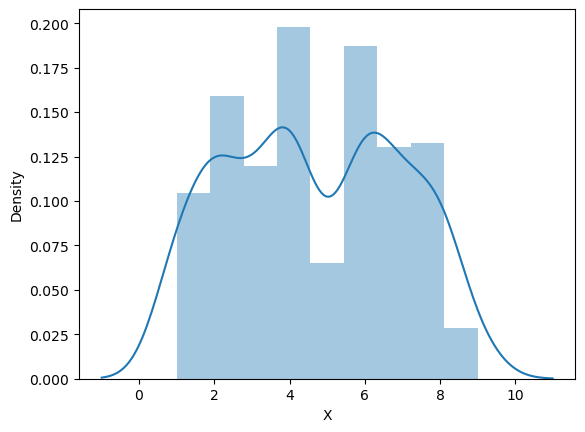

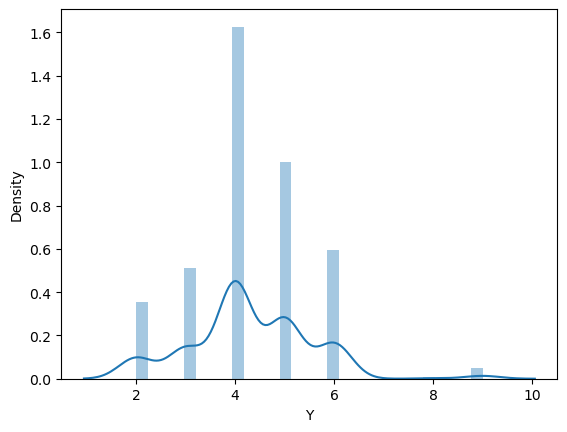

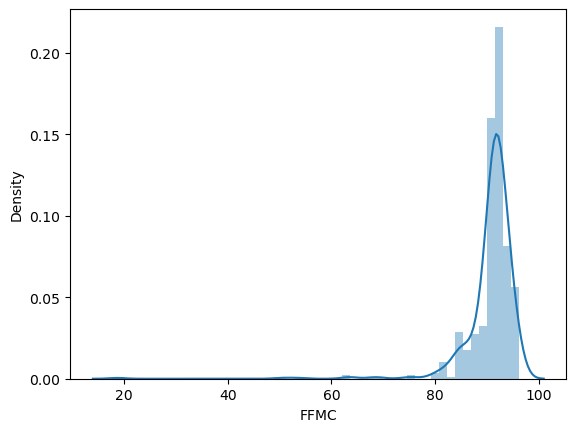

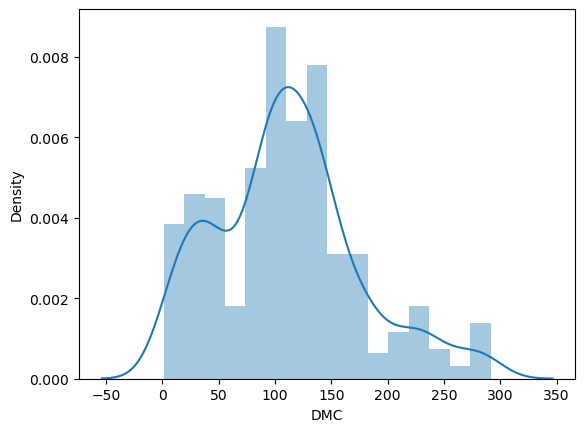

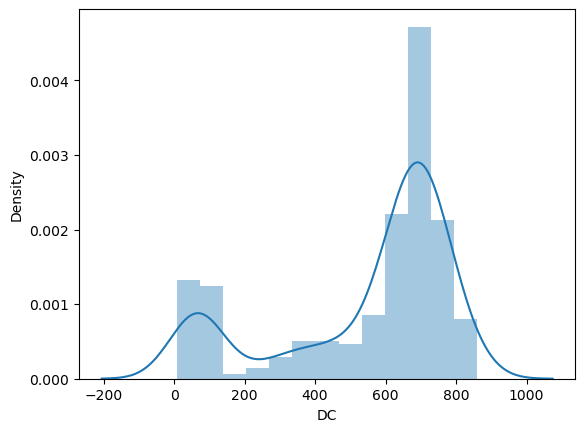

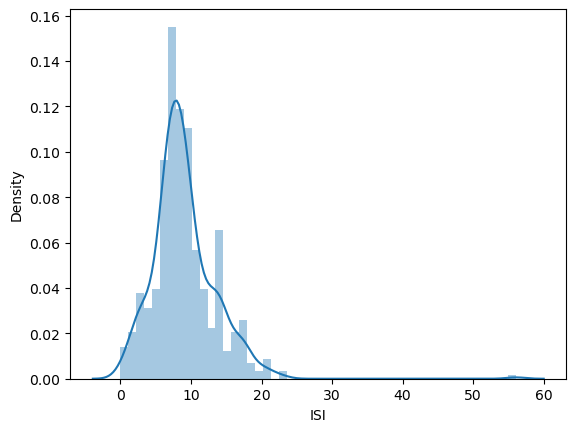

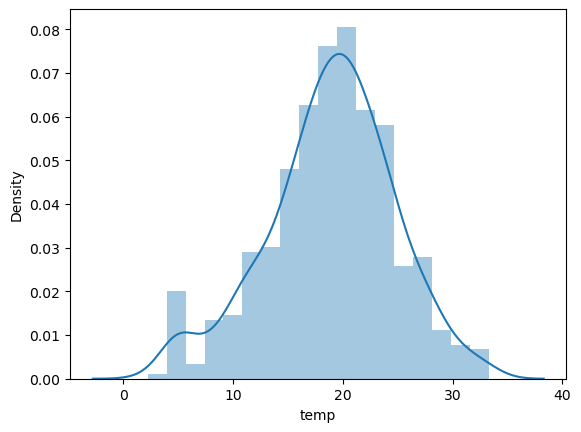

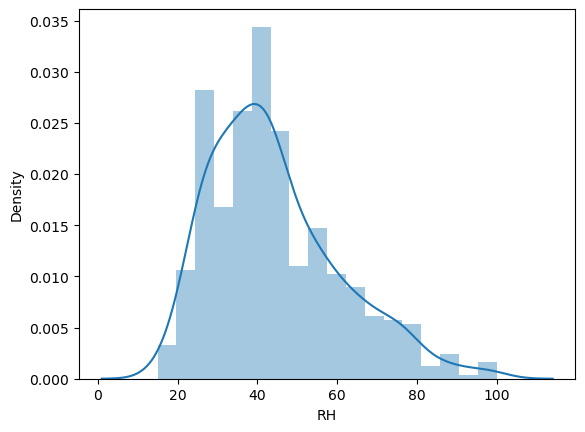

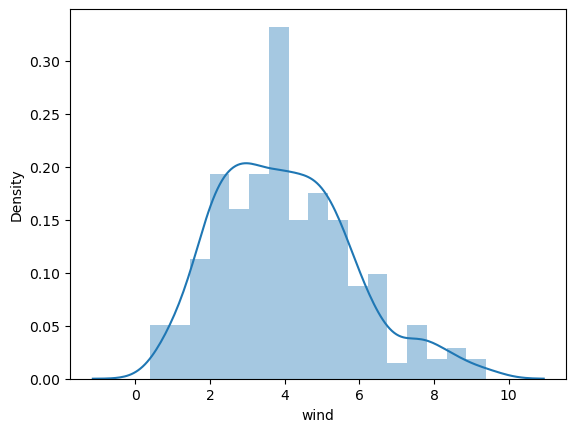

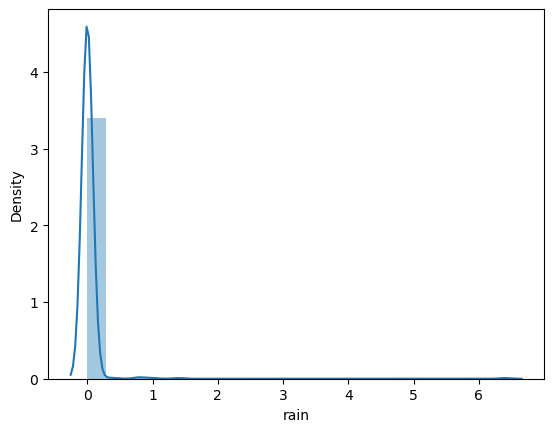

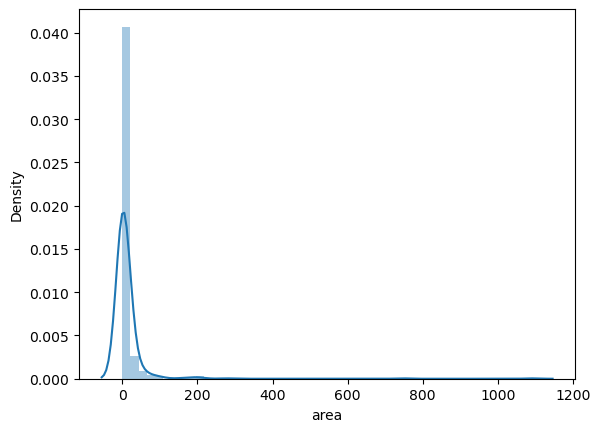

In [25]:
catg_cols = ['month', 'day']  

for i in df.columns:
    if i in catg_cols:  
        continue
    else:
        sns.distplot(df[i])
        plt.show()

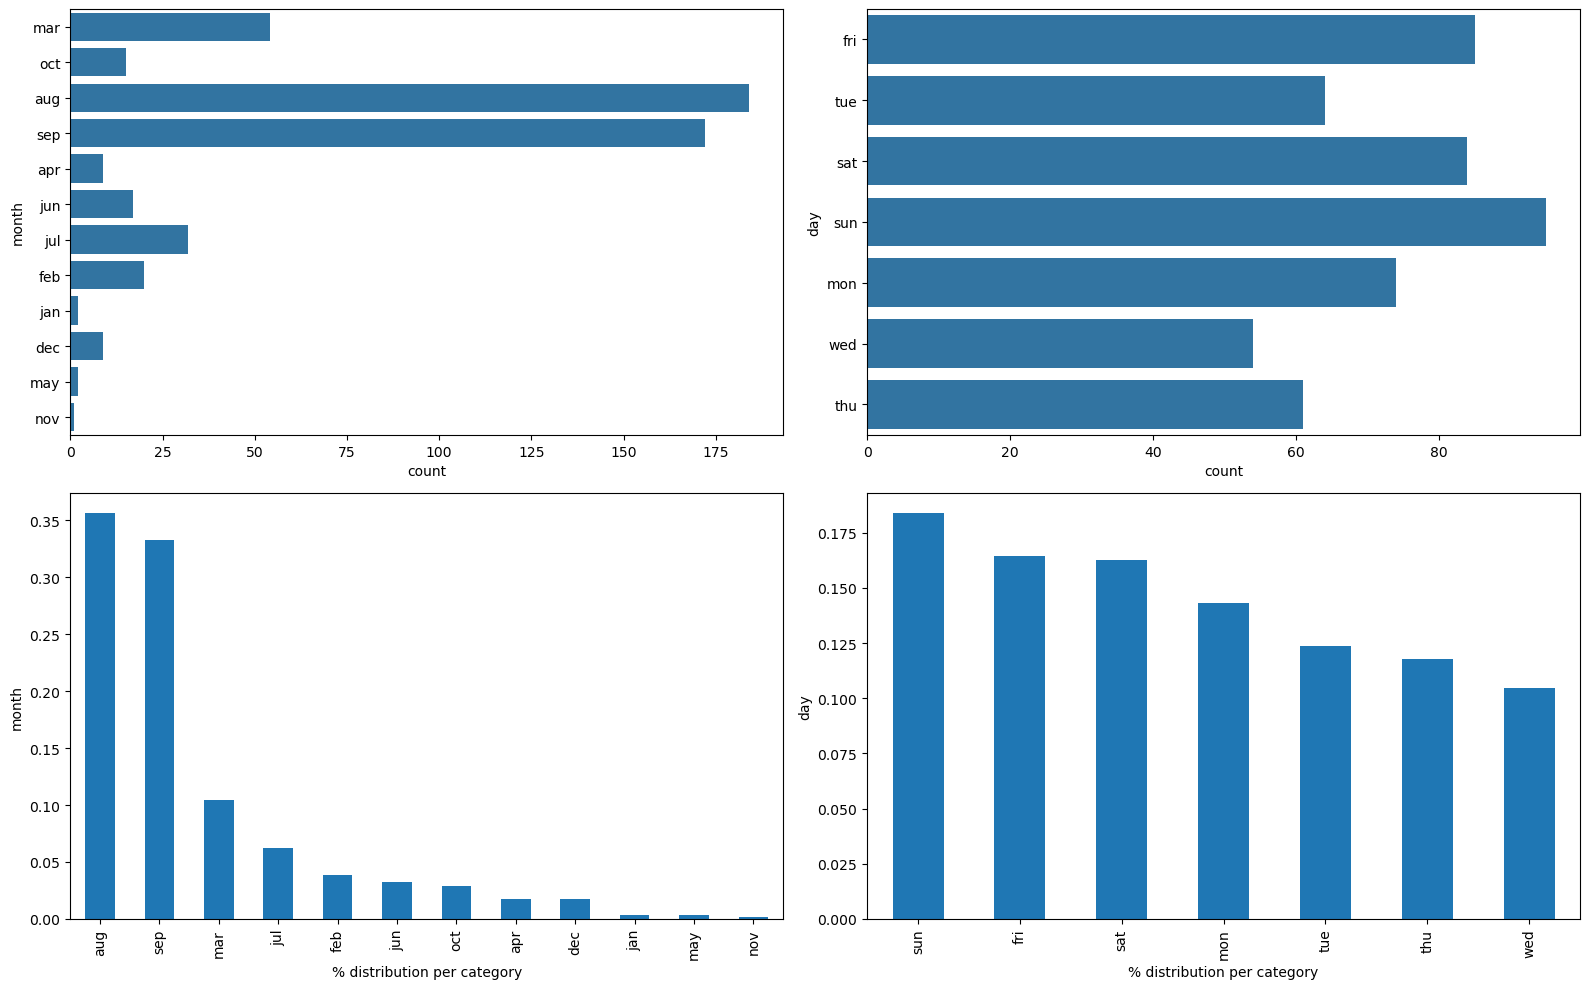

In [26]:
# analyzing categorical columns
plt.figure(figsize=(16,10))
for i,col in enumerate(catg_cols,1):
    plt.subplot(2,2,i)
    sns.countplot(data=df,y=col)
    plt.subplot(2,2,i+2)
    df[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show() 

In [27]:
num_cols = [col for col in df.columns if df[col].dtype in ["int32","int64","float32","float64"]]
catg_cols = [col for col in df.columns if df[col].dtype not in ["int32","int64","float32","float64"]]

if (num_cols) and (catg_cols):
    print("num columns is\n",num_cols)
    print("catg columns is\n",catg_cols)
    
elif catg_cols:
        print("catg columns is\n",catg_cols)

else:
    print("num columns is\n",num_cols)

num columns is
 ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']
catg columns is
 ['month', 'day']


# for i, col in enumerate(num_cols, 1):: Loops through each numerical column in num_cols, assigning an index i (starting from 1) and the column name to col.
# plt.subplot(8, 4, i): Divides the figure into a grid of 8 rows and 4 columns, and selects the i-th subplot for plotting.

# sns.kdeplot(df[col], color='g', shade=True): Creates a kernel density estimate (KDE) plot for the current column (df[col]), visualizing its distribution. The plot is colored green (color='g') and shaded for better visualization (shade=True).

# plt.subplot(8, 4, i + 10): Selects the subplot next to the KDE plot (index i + 10) for the box plot.
# df[col].plot.box(): Creates a box plot for the current column, showing its distribution, quartiles, and outliers.

# plt.tight_layout(): Adjusts spacing between subplots for better readability.
# plt.show(): Displays the generated figure containing all KDE and box plots.

# num_data = df[num_cols]: Selects only numerical columns from the DataFrame df.
# pd.DataFrame(data=[num_data.skew(), num_data.kurtosis()], index=['skewness', 'kurtosis']): Creates a DataFrame displaying skewness and kurtosis values for each numerical column, providing insights into their distribution shapes.



In [28]:
len(num_cols)

11

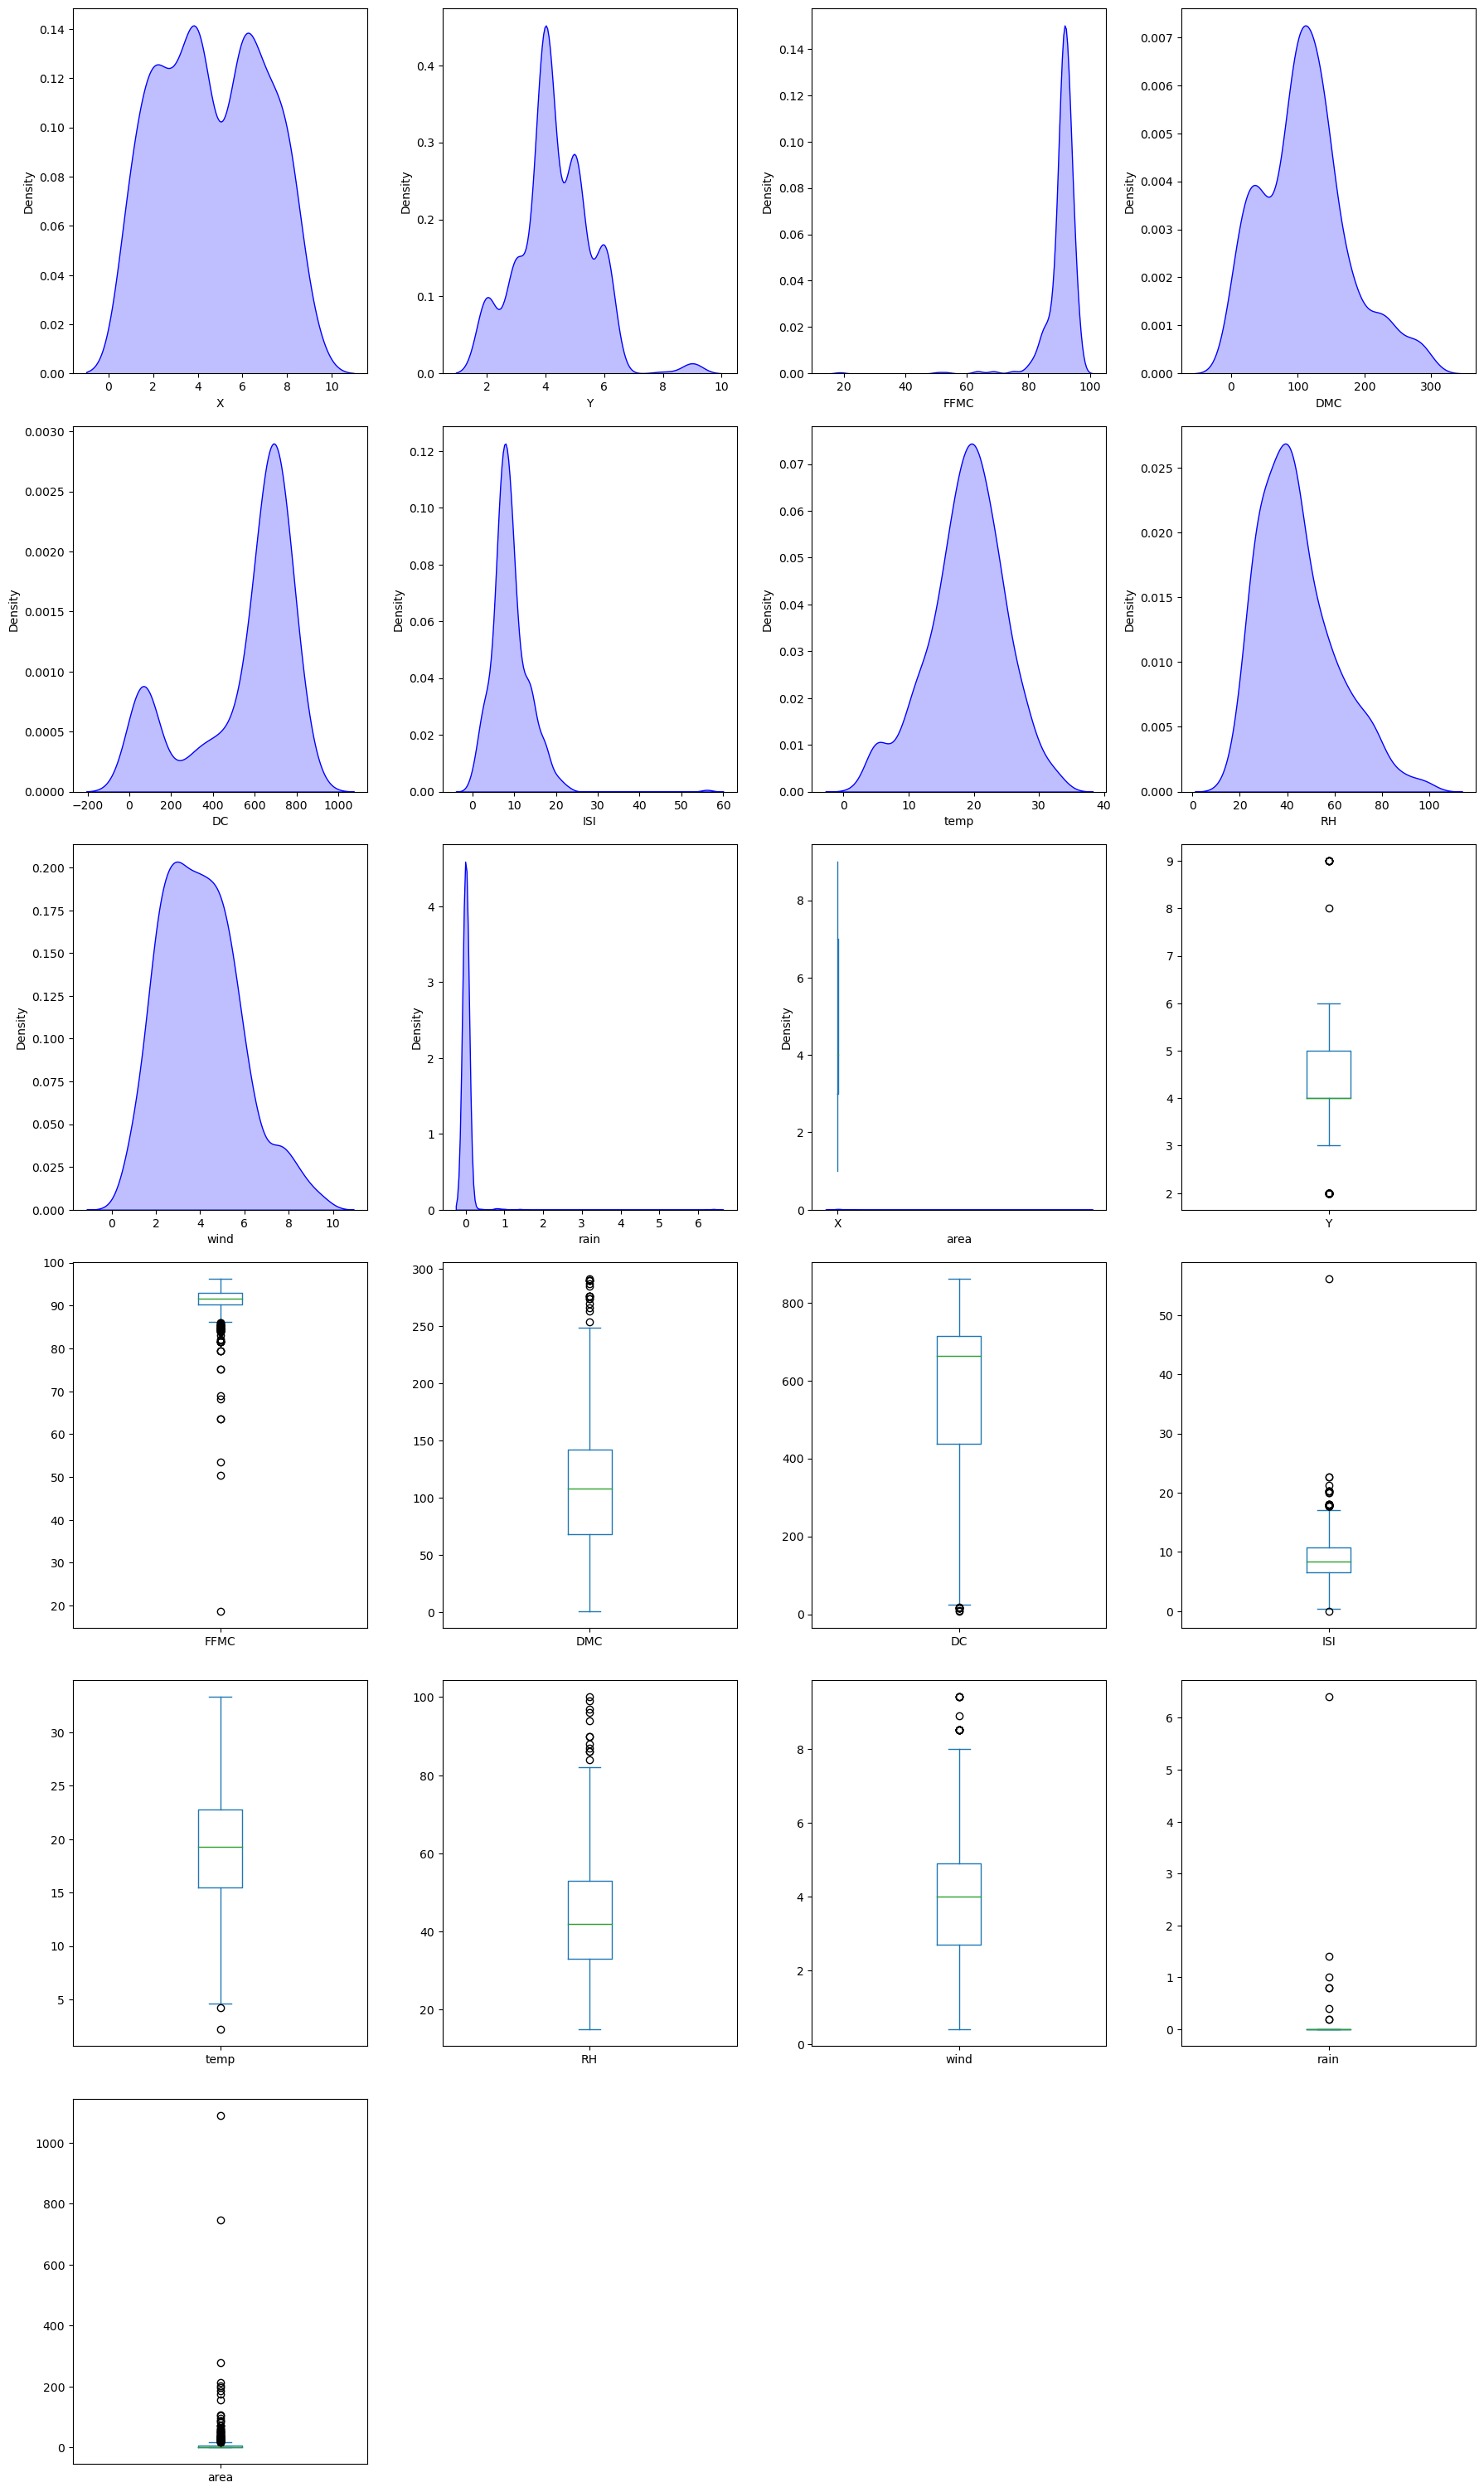

X         Y       FFMC       DMC        DC        ISI  \
skewness  0.036246  0.417296  -6.575606  0.547498 -1.100445   2.536325   
kurtosis -1.172331  1.420553  67.066041  0.204822 -0.245244  21.458037   

              temp        RH      wind        rain        area  
skewness -0.331172  0.862904  0.571001   19.816344   12.846934  
kurtosis  0.136166  0.438183  0.054324  421.295964  194.140721

In [29]:
plt.figure(figsize=(18,40))
for i,col in enumerate(num_cols,1):
    plt.subplot(8,4,i)
    sns.kdeplot(df[col],color='b',shade=True)
    plt.subplot(8,4,i+10)
    df[col].plot.box()
plt.tight_layout() 
plt.show()
num_data = df[num_cols]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

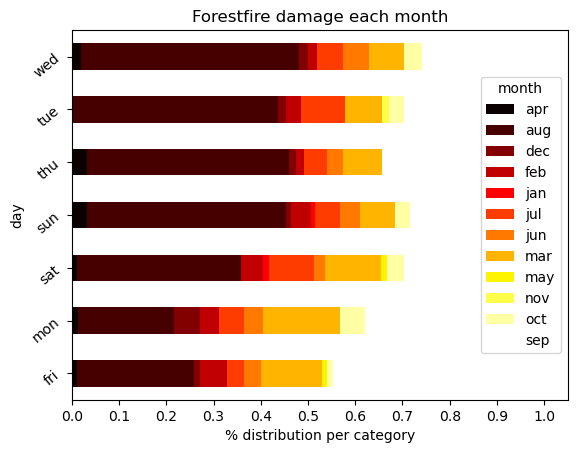

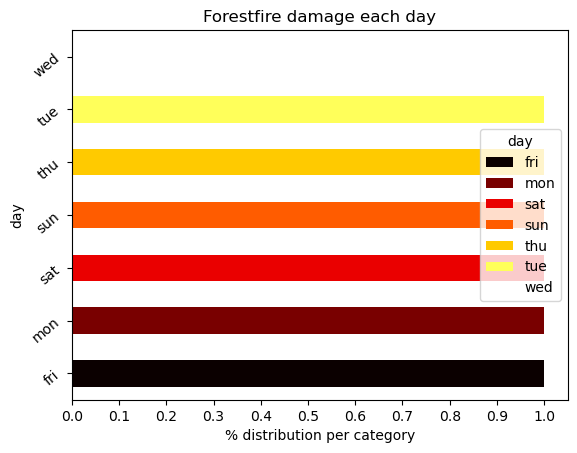

In [30]:
for col in catg_cols:
    cross = pd.crosstab(index=df['day'],columns=df[col],normalize='index')
    cross.plot.barh(stacked=True,rot=40,cmap='hot')
    plt.xlabel('% distribution per category')
    plt.xticks(np.arange(0,1.1,0.1))
    plt.title("Forestfire damage each {}".format(col))
plt.show()

In [31]:
target = "area"

Skew: 12.846933533934868
Kurtosis: 194.1407210942299


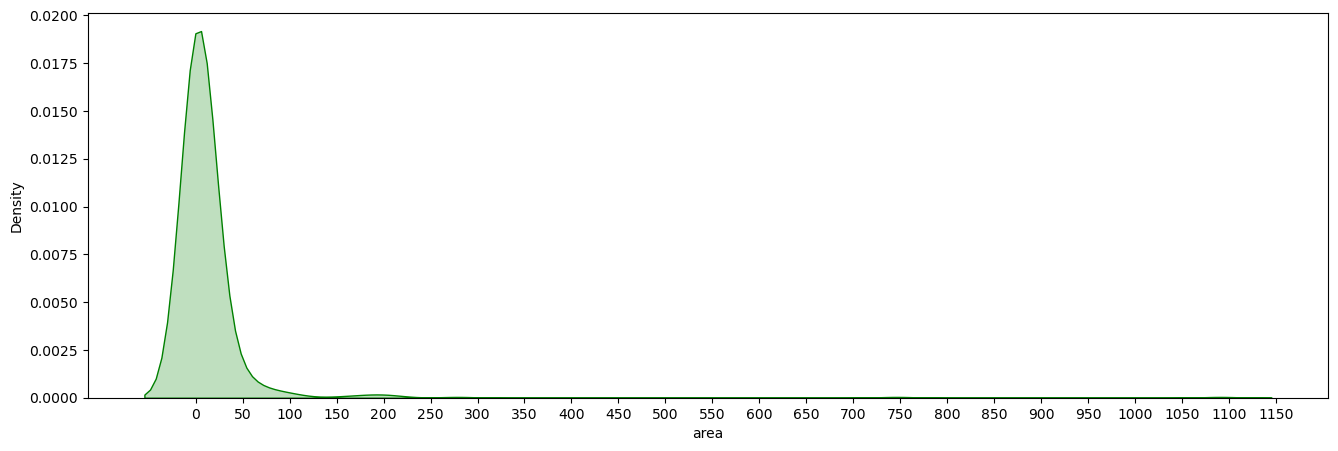

In [32]:
plt.figure(figsize=(16,5))
print("Skew: {}".format(df[target].skew()))
print("Kurtosis: {}".format(df[target].kurtosis()))
ax = sns.kdeplot(df[target],shade=True,color='g')
plt.xticks([i for i in range(0,1200,50)])
plt.show()

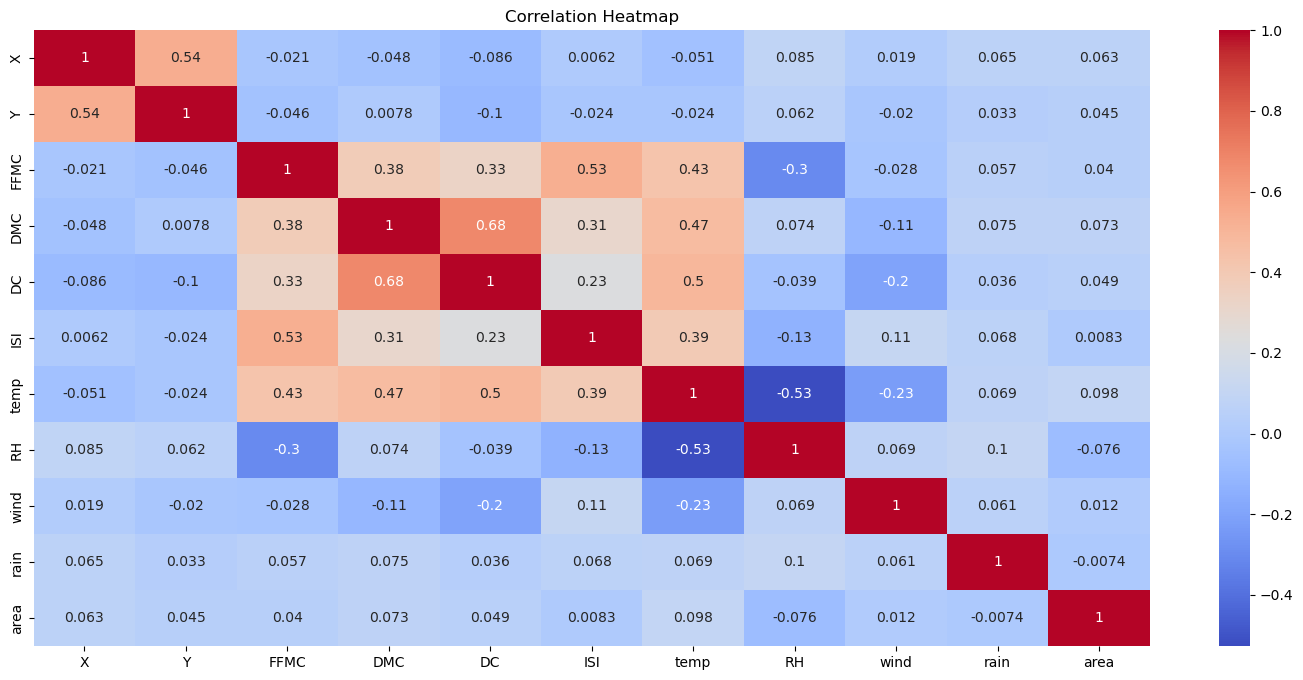

In [33]:
plt.figure(figsize=(18, 8))
sns.heatmap(df.corr() ,annot=True , cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [34]:
df = df.drop(["day","month"],axis=1)
df

X  Y  FFMC    DMC     DC   ISI  temp  RH  wind  rain   area
0    7  5  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0   0.00
1    7  4  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0   0.00
2    7  4  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0   0.00
3    8  6  91.7   33.3   77.5   9.0   8.3  97   4.0   0.2   0.00
4    8  6  89.3   51.3  102.2   9.6  11.4  99   1.8   0.0   0.00
..  .. ..   ...    ...    ...   ...   ...  ..   ...   ...    ...
512  4  3  81.6   56.7  665.6   1.9  27.8  32   2.7   0.0   6.44
513  2  4  81.6   56.7  665.6   1.9  21.9  71   5.8   0.0  54.29
514  7  4  81.6   56.7  665.6   1.9  21.2  70   6.7   0.0  11.16
515  1  4  94.4  146.0  614.7  11.3  25.6  42   4.0   0.0   0.00
516  6  3  79.5    3.0  106.7   1.1  11.8  31   4.5   0.0   0.00

[517 rows x 11 columns]

In [35]:
X = df.drop(["area"],axis=1)
y = df["area"]

In [36]:
X_train , X_test ,y_train , y_test = train_test_split(X , y , test_size=0.2 , shuffle=True , random_state=123)

In [37]:
print(f"the shape of X_train is {X_train.shape}")
print(f"the shape of X_test is {X_test.shape}")
print(f"the shape of y_train is {y_train.shape}")
print(f"the shape of y_test is {y_test.shape}")

the shape of X_train is (413, 10)
the shape of X_test is (104, 10)
the shape of y_train is (413,)
the shape of y_test is (104,)


In [38]:
col_nums = [col for col in X.columns if df[col].dtype in ["int32", "int64", "float32", "float64"]]
col_catg = [col for col in X.columns if df[col].dtype not in ["int32", "int64", "float32", "float64"]]

if (col_nums) and (col_catg):
    print(f" nums cols is \n {col_nums}")
    print(f" catg cols is \n {col_catg}")

elif col_catg:
        print(f" catg cols is \n {col_catg}")

else:
    print(f" nums cols is \n {col_nums}")


 nums cols is 
 ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']


In [39]:
df.columns

Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'area'],
      dtype='object')

In [40]:
## Assuming "EUR/USD" is a valid column name
pip_num = Pipeline(steps=[("select", DataFrameSelector(col_nums)),
                           ("Simple", SimpleImputer(strategy="median")),
                           ("scaler", StandardScaler())])

# X_train_nums = pip_num.fit_transform(X_train , y_train)

In [41]:
pip_catg = Pipeline(steps=[
                 ("selector", DataFrameSelector(col_catg)),# ==> To select the categorical cols from the Data
                 ("Imputer", SimpleImputer(strategy="constant", fill_value="missing")),
                 ("one_hot", LabelEncoder())
                ])


In [42]:
def Preprocessing(cols_nums, col_catg, X_train, X_test):
    if cols_nums and col_catg:
        # total pipeline to concatenate the num_pipeline and cate_pipeline
        total_pipeline = FeatureUnion(transformer_list=[("num_pipeline", pip_num),
                                                        ("cate_pipeline", pip_catg)])

        # make fitting
        pip_num.fit(X_train)
        X_train_final= pip_num.transform(X_train)
        X_test_final =  pip_num.transform(X_test)

        return X_train_final, X_test_final

    elif col_catg == [] and cols_nums:
        # make fitting
        pip_num.fit(X_train)
        X_train_final= pip_num.transform(X_train)
        X_test_final =  pip_num.transform(X_test)

        return X_train_final, X_test_final

    else:
        # make fitting
        pip_num.fit(X_train)
        X_train_final= pip_num.transform(X_train)
        X_test_final =  pip_num.transform(X_test)

        return X_train_final, X_test_final



X_train_final, X_test_final = Preprocessing(col_nums, col_catg, X_train, X_test)
print(f"X_train_final is = {X_train_final}")
print("*"*50)
print(f"X_test_final is = {X_test_final}")


X_train_final is = [[-1.15562915  0.65573506  0.67284232 ... -0.26455224  1.2223615
  -0.08059268]
 [-0.27666996 -0.20400646 -0.12289357 ... -0.14301712  1.44317519
  -0.08059268]
 [-0.27666996 -0.20400646  0.93091882 ...  0.82926387 -1.53780963
  -0.08059268]
 ...
 [ 1.48124842  1.51547659  0.9524252  ... -0.93299542 -1.26179252
  -0.08059268]
 [ 0.60228923  0.65573506  0.24271481 ...  0.03928557 -0.54414802
  -0.08059268]
 [ 0.60228923  0.65573506  0.04915743 ...  1.07233412  0.7255307
  -0.08059268]]
**************************************************
X_test_final is = [[  1.92072801   0.65573506   0.54380406 ...  -0.62915761   0.22869989
   -0.08059268]
 [ -0.27666996   0.65573506 -15.49995197 ...   3.38150147  -1.75862332
   -0.08059268]
 [  1.04176882   1.51547659   0.09217018 ...   2.77382585   1.94000599
    0.52458506]
 ...
 [  0.60228923  -1.06374799   0.0706638  ...  -0.3253198   -0.26813091
   -0.08059268]
 [  1.92072801   4.09470117   0.52229769 ...  -1.17606567   0.2286998

## Model ML

# RandomForestRegressor

In [43]:
random = RandomForestRegressor()

In [44]:
hayper_params = {
    "n_estimators" : [i for i in range(100,500,50)],
    "max_depth" : [i for i in range(3,15,4)],
    "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"]
}


random_hyper = RandomizedSearchCV(
    estimator=random,
    param_distributions=hayper_params,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1
)


# Fit the model
random_model = random_hyper.fit(X_train_final, y_train)

In [45]:
print(f"Best Parameter is \n {random_model.best_params_}")

Best Parameter is 
 {'n_estimators': 400, 'max_depth': 3, 'criterion': 'absolute_error'}


In [46]:
Rand_reg = random_model.best_estimator_
Rand_reg

RandomForestRegressor(criterion='absolute_error', max_depth=3, n_estimators=400)

In [47]:
cross_val = cross_val_score(estimator=Rand_reg , X=X_train_final , y=y_train ,
                            cv=5 , scoring="neg_mean_squared_error" , n_jobs=-1)

 
print("Score is ==>>\n ",abs(cross_val))

print("cross val score mean is ==>> ",cross_val.mean() * -1)

Score is ==>>
  [  740.63021658  1670.17124846 21488.23939445   623.14680559
   687.13573828]
cross val score mean is ==>>  5041.864680672641


In [48]:
# Make cross-validation predictions
cross_val_pred = cross_val_predict(estimator=Rand_reg, X=X_train_final, y=y_train,
                                   cv=5, method="predict", n_jobs=-1)

# Calculate mean squared error
mse = np.sqrt(mean_squared_error(y_train, cross_val_pred))

# Print the MSE
print(f"The mean squared error is {mse:.4f}")

The mean squared error is 71.0930


In [49]:
feat_import_forst = {}
for name , score in zip(col_nums , Rand_reg.feature_importances_[:6]):
    feat_import_forst[name] = score


In [50]:
keys_forst = feat_import_forst.keys()
values_forst = feat_import_forst.values()

In [51]:
X = pd.DataFrame({"features": keys_forst, "Scores": values_forst})


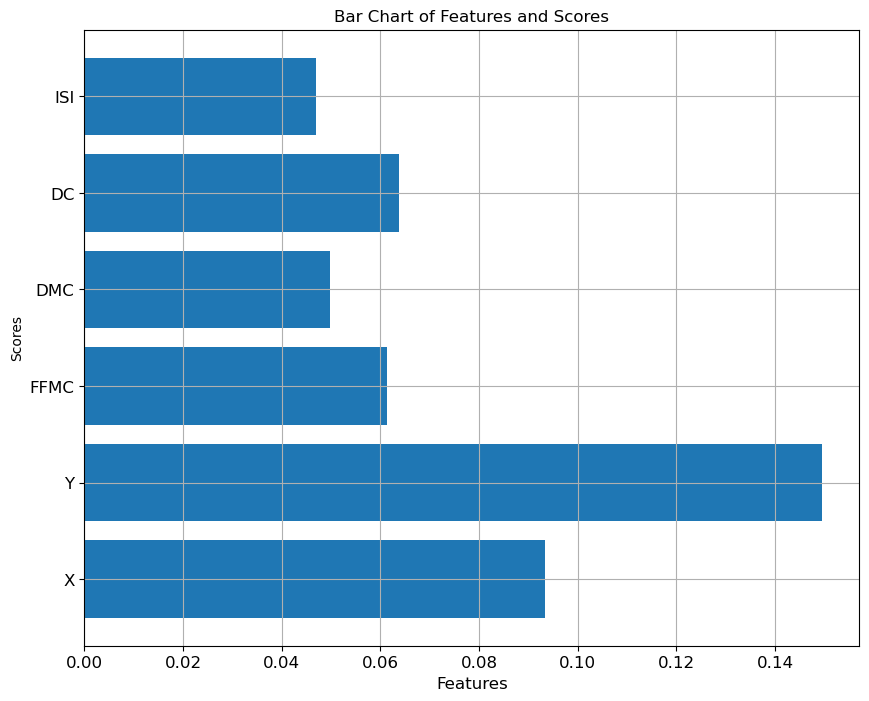

In [52]:
plt.figure(figsize=(10, 8))
plt.barh(X["features"], X["Scores"])
plt.xlabel("Features", fontsize=12)
plt.ylabel("Scores")
plt.title("Bar Chart of Features and Scores")
plt.xticks(c="k", fontsize=12)
plt.yticks(c="k", fontsize=12)
plt.grid(True)
plt.show()


In [53]:
test_predictions = Rand_reg.predict(X_test_final)  

In [54]:
pd.DataFrame(np.c_[test_predictions , y_test] , columns=["prediction" , "actual"])

prediction  actual
0     11.849412    8.16
1      6.750388    0.00
2      0.682200    0.00
3      0.317225    0.00
4      0.241400   29.48
..          ...     ...
99     0.637663    0.00
100    0.759575    6.10
101    0.241900    1.56
102   43.336275    2.75
103    0.645263    0.00

[104 rows x 2 columns]

# XGBRegressor

In [55]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train_final , y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [56]:
cross_val_xgb = cross_val_score(estimator=xgb_reg , X=X_train_final , y=y_train ,
                            cv=5 , scoring="neg_mean_squared_error" , n_jobs=-1)

 
print("Score is ==>>\n ",abs(cross_val_xgb))

print("cross val score mean is ==>> ",cross_val_xgb.mean() * -1)

Score is ==>>
  [13162.74521371 13408.27695348 21630.45633994   810.83440597
  6965.20663161]
cross val score mean is ==>>  11195.503908943214


In [57]:
# Make cross-validation predictions
cross_val_pred = cross_val_predict(estimator=xgb_reg, X=X_train_final, y=y_train,
                                   cv=5, method="predict", n_jobs=-1)



# Calculate mean squared error
mse =np.sqrt(mean_squared_error(y_train, cross_val_pred))
# Print the MSE
print(f"The mean squared error is {mse:.4f}")

The mean squared error is 105.9759


In [58]:
param_xgb = {
     "n_estimators" : np.arange(50, 200, 10),
    "max_depth" : np.arange(2, 10, 1),
    "learning_rate" : np.arange(0.1, 1, 0.1),
    "subsample" : np.arange(0.2, 1, 0.25),
    "alpha" :  np.arange(0.1, 1, 0.1)
}

grid_xgb = RandomizedSearchCV(estimator=xgb_reg , param_distributions=param_xgb , n_jobs=-1 ,
                    verbose=6 , n_iter=500 , cv=5 , scoring="neg_mean_squared_error")
grid_xgb.fit(X_train_final , y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   n_iter=500, n_jobs=-1,
                   param_distributions={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190]),
                                        'subsample': array([0.2 , 0.45, 0.7 , 0.95])},
                   scoring='neg_mean_squared_error', verbose=6)

In [59]:
pest_para = grid_xgb.best_params_
pest_para

{'subsample': 0.2,
 'n_estimators': 50,
 'max_depth': 6,
 'learning_rate': 0.1,
 'alpha': 0.5}

In [60]:
best_est = grid_xgb.best_estimator_
best_est

XGBRegressor(alpha=0.5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, ...)

In [61]:
cross_val_xgb_sc = cross_val_score(estimator=grid_xgb , X=X_train_final , y=y_train ,
                            cv=5 , scoring="neg_mean_squared_error" , n_jobs=-1)

 
print("Score is ==>>\n ",abs(cross_val_xgb_sc))

print("cross val score mean is ==>> ",cross_val_xgb_sc.mean() * -1)

Score is ==>>
  [ 1126.19439535  3051.48734566 21121.79507195  1028.33679581
  1647.91684768]
cross val score mean is ==>>  5595.146091289016


In [62]:
# Make cross-validation predictions
cross_val_pred_xgb = cross_val_predict(estimator=grid_xgb, X=X_train_final, y=y_train,
                                   cv=5, method="predict", n_jobs=-1)

# Calculate mean squared error
mse = np.sqrt(mean_squared_error(y_train, cross_val_pred_xgb))

# Print the MSE
print(f"The mean squared error is {mse:.4f}")

The mean squared error is 74.9251


In [63]:
feat_import_forst = {}
for name , score in zip(col_nums , best_est.feature_importances_[:17]):
    feat_import_forst[name] = score

    
keys_forst = feat_import_forst.keys()
values_forst = feat_import_forst.values()

pd.DataFrame({"features" : keys_forst , "Scores" : values_forst})


features    Scores
0        X  0.085276
1        Y  0.040019
2     FFMC  0.159451
3      DMC  0.153967
4       DC  0.020837
5      ISI  0.021632
6     temp  0.306548
7       RH  0.174539
8     wind  0.037730
9     rain  0.000000

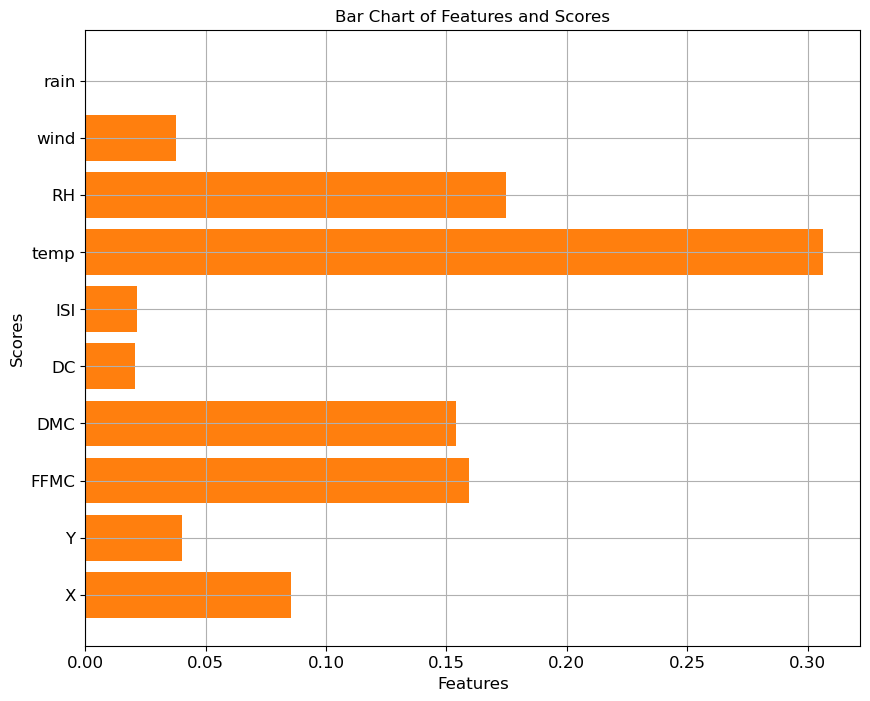

In [64]:
plt.figure(figsize=(10,8))
x = pd.DataFrame({"features": keys_forst, "Scores": values_forst})
plt.barh(y=x["features"], width=x["Scores"])  

plt.barh(y=x["features"], width=x["Scores"])  
plt.xlabel("Features", fontsize=12)
plt.ylabel("Scores" , fontsize=12)
plt.title("Bar Chart of Features and Scores")
plt.xticks(c="k", fontsize=12)
plt.yticks(c="k", fontsize=12)
plt.grid(True)
plt.show()


# END

# DY : SAYED ALI